<a href="https://colab.research.google.com/github/giacomominello/AI4S/blob/master/AI4S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARTIFICIAL INTELLIGENCE FOR SECURITY - Assignment: Analysing Network Traffic

Let's start by importing some libraries and loading some extensions. 

In [0]:
import pandas as pd #https://pandas.pydata.org/pandas-docs/stable/index.html
import numpy as np #https://numpy.org/devdocs/ 
import time 
import seaborn as sns
import matplotlib.pyplot as plt #https://matplotlib.org/api/pyplot_api.html
from ipywidgets import widgets #https://ipywidgets.readthedocs.io/en/latest/
from ipywidgets import interact #"It's a surprise tool that will help us later" 
%load_ext google.colab.data_table
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import check_random_state
random_state = np.random.RandomState(42) #should allow us to have deterministic results (up to roundoff error)(kind of)(at least it's more consistent)

### First load the dataset for week 1 into a python notebook.
- We will use data from week 1 for training a system and keep the week 2 data for testing purposes only.

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1Gjcq50EpQOH-t-dwQVRP6MmO7JRiRDUf'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CIDDS-001-internal-week1_10pcSample.csv')  
df = pd.read_csv('CIDDS-001-internal-week1_10pcSample.csv',index_col=[0],dtype={'Bytes': object})



In [0]:
df.head(100)

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
23,2017-03-15 00:01:17.728,0.047,TCP,192.168.220.16,45586,10000_35,443.0,5,906,1,.AP.S.,0,normal,---,---,---
36,2017-03-15 00:01:18.457,0.170,TCP,10003_195,80,192.168.220.16,48286.0,3,908,1,.AP.S.,32,normal,---,---,---
30,2017-03-15 00:01:18.511,0.003,TCP,10002_113,443,192.168.220.16,49062.0,2,1089,1,.AP...,32,normal,---,---,---
46,2017-03-15 00:01:22.400,0.000,TCP,EXT_SERVER,8082,192.168.220.15,37039.0,1,212,1,.AP...,32,normal,---,---,---
51,2017-03-15 00:01:24.152,0.266,TCP,192.168.200.9,52290,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,2017-03-15 00:06:10.876,0.000,UDP,DNS,53,192.168.220.16,36031.0,2,565,1,......,0,normal,---,---,---
954,2017-03-15 00:06:21.221,0.323,TCP,192.168.220.16,48573,10003_195,80.0,5,2408,1,.AP.S.,0,normal,---,---,---
947,2017-03-15 00:06:21.349,0.000,UDP,DNS,53,192.168.220.16,42319.0,2,565,1,......,0,normal,---,---,---
949,2017-03-15 00:06:21.575,0.000,UDP,DNS,53,192.168.220.16,49715.0,2,565,1,......,0,normal,---,---,---


### Describe the data:
- How many columns and how many rows are there?

In [0]:
print("Number of rows =", len(df.index)) ## or print("Number of rows =", df.shape[0])

Number of rows = 845152


In [0]:
print("Number of columns =", len(df.columns)) ## or df.shape[1]

Number of columns = 16


- How many unique values does the 'class' attribute take?


In [0]:
print("Number of unique values =", len(df['class'].unique()))
print("Unique values =", df['class'].unique())

Number of unique values = 3
Unique values = ['normal' 'attacker' 'victim']


- How many rows are there for each unique value of the class attribute?


In [0]:
print(df['class'].value_counts())

normal      700513
attacker     75124
victim       69515
Name: class, dtype: int64


- What unique values does the 'attackType' attribute take on?


In [0]:
print("Number of unique values =", len(df['attackType'].unique()))
print("Unique values =", df['attackType'].unique())

Number of unique values = 5
Unique values = ['---' 'portScan' 'dos' 'pingScan' 'bruteForce']


- List the count of each of the possible attack types.

In [0]:
print(df['attackType'].value_counts())

---           700513
dos           125430
portScan       18686
pingScan         355
bruteForce       168
Name: attackType, dtype: int64


### Have a look at the other columns:
- Which columns contain numeric values?


In [0]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df.select_dtypes(include=numerics).columns

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Flows', 'Tos'], dtype='object')

*N.b. The column "Bytes" is not considered as a numeric one because it contains mixed values (such as numeric and strings).*

- Do they all correspond to "numeric variables" or are some of them categorical? Note that categorical values are often expressed as numbers! (For numeric types, comparisons with with “>” and “<” makes sense, for categorical variables they don’t.)


No, not all of them. Only 'Duration', ' and 'Packets'.

- List all numeric types and compute simple statistics (minimum, maximum, average, etc.) for each.


In [0]:
print(df.Duration.describe(), "\n")
print(df.Packets.describe())

count    845152.000000
mean          0.113840
std           0.760426
min           0.000000
25%           0.000000
50%           0.000000
75%           0.025000
max         135.403000
Name: Duration, dtype: float64 

count    845152.000000
mean         14.902497
std         978.309853
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      195912.000000
Name: Packets, dtype: float64


- Plot the distribution of the numeric variables using a histogram. Do any of the values look too large or too small?

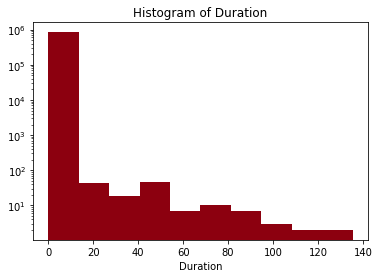

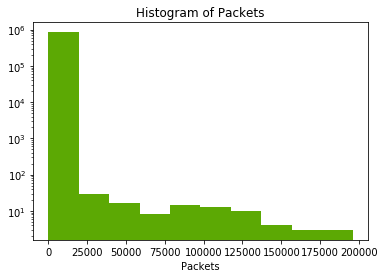

In [0]:
plt.title('Histogram of Duration')
plt.xlabel('Duration')
plt.hist(df['Duration'].values, color='xkcd:crimson', log=True)
plt.show() 

plt.title('Histogram of Packets')
plt.xlabel('Packets')
plt.hist(df['Packets'].values, color='xkcd:leaf green', log=True)
plt.show()

### Have a look at the times and dates that the system has come under attack:
- Convert the 'Date first seen' column to a datetime object (see code in Appendix).


In [0]:
df['Date first seen'] = pd.to_datetime(df['Date first seen'])

- Create new columns for the day-of-week or time-of-day.


In [0]:
df['Day of week'] = df['Date first seen'].dt.dayofweek
df['Time of day'] = df['Date first seen'].dt.hour
print("Day of the week =", df['Day of week'].unique())
print("Time of day =", df['Time of day'].unique())

Day of the week = [2 3 4 5 6 0 1]
Time of day = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


- Plot histograms of the day-of-week and of the time-of-day to see their distribution in the data.


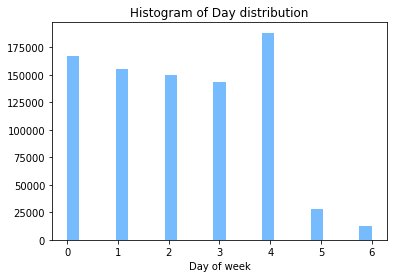

In [0]:
plt.title('Histogram of Day distribution')
plt.xlabel('Day of week')
plt.hist(df['Day of week'].values, color='xkcd:sky blue', bins=25)
plt.show()

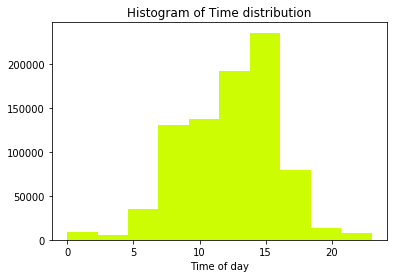

In [0]:
plt.title('Histogram of Time distribution')
plt.xlabel('Time of day')
plt.hist(df['Time of day'].values, color='xkcd:greenish yellow')
plt.show()

- Select only the rows corresponding to attacks and replot the histograms.


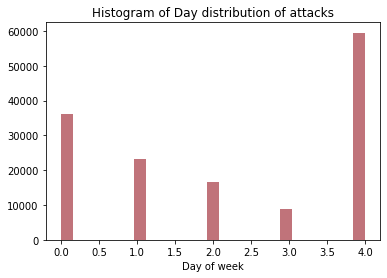

In [0]:
plt.title('Histogram of Day distribution of attacks')
plt.xlabel('Day of week')
plt.hist(df[(df['class']=="attacker")| (df['class']=="victim")]['Day of week'].values, color='xkcd:dusty rose', bins=25)
plt.show()

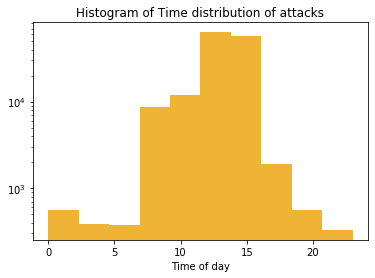

In [0]:
plt.title('Histogram of Time distribution of attacks')
plt.xlabel('Time of day')
plt.hist(df[(df['class']=="attacker")| (df['class']=="victim")]['Time of day'].values, color='xkcd:macaroni and cheese', log=True)
plt.show()

- Does the day-of-week or time-of-day affect the probability of seeing an attack?

Yes! 

Some other visualization:

Sometimes our features may be closely related to other features. We can easily calculate the correlation coefficient between pairs of features.

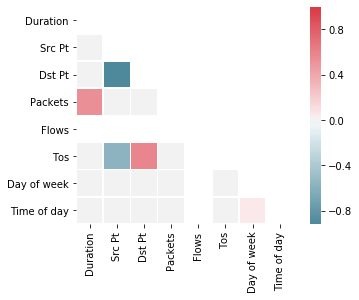

In [0]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, center=0, vmax=1);

In [0]:
feature_desc = {'Duration': 'Duration', 'Packets': 'Packets','Day of week' : 'Day of week','Time of day':'Time of day'}
def plot_feature(column):
    plt.plot(df['class'], df[column], '.')
    plt.xlabel(feature_desc[column])
    plt.ylabel('Class')

dropdown_menu = {v: k for k, v in feature_desc.items()}

widgets.interact(plot_feature, column=dropdown_menu);
#no attaks on weekends
#unbalanced features

interactive(children=(Dropdown(description='column', options={'Duration': 'Duration', 'Packets': 'Packets', 'D…

### Now create some classifiers using just the numeric attributes and try to predict the ‘class’:
- Train a logistic regression classifier.


In classification, we predict categorical labels. In regression, we predict quantitative/numerical labels. The critical difference is that we can't take a difference between the predicted and actual category in classification, while we can take a difference between the predicted and actual numerical values in regression. Because of these differences between regression and classification, we use different metrics to evaluate machine learning models trained for classification.

As with regression, we're trying to determine the model $f$ that can best describes the relationship

$$ y_j = f(X_j). $$

For classification, $y_j$ can only take a finite set of values. If there are only two such values, we are dealing with **binary** classification. Examples of binary classification are predicting whether it will rain or not and whether someone will default on their loan. If we have more than two classes, we have a **multiclass** problem. For example, image classification is usually multiclass as we are trying to identify an image among a set of values, e.g., a person, a road sign, a car, etc.

In [0]:
X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets']],  
    df[['class']], 
    test_size=0.20
)

The logistic regression model is the classifier version of linear regression. It is a probabilistic model; it will predict probability values that can then be used to assign class labels. The model works by taking the output of a linear regression model and feeds it into a sigmoid or logistic function. Mathematically

$$ p_j = S\left( \sum_{i} X_{ji}\beta_i  + \beta_0 \right), $$
where
$$ S(x) = \frac{1}{1 + e^{-x}} $$

The reason for the sigmoid function is that it maps values that range from positive to negative infinity to values that only range from 0 to 1. Thus, the output of the sigmoid function can be interpreted as a probability.

The $\beta$ coefficients of the model are chosen to minimize the log loss. Unlike linear regression, there is no closed-form solution to the optimal coefficient. Instead, the coefficients are solved using gradient descent.

In [0]:
from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr = LogisticRegression(solver='lbfgs', max_iter=1500, verbose=1, n_jobs=-1,multi_class='multinomial')

# train the classifier
t0 = time.time()
clf_lr.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
y_pred_lr = clf_lr.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


elapsed time = 54.95


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.7s finished


- How well does the classifier perform in terms of accuracy on the TRAINING data?


A natural choice for a metric for classification is accuracy. Accuracy is equal to the number of observations you correctly classified over all observations. For example, if your model properly identified 77 out of 100 images, you have an accuracy of 77%. Accuracy is an easy metric to both understand and calculate. Mathematically, it is simply

$$ \frac{\text{number of correct observations}}{\text{number of observations}}.$$

However, accuracy may not always be a good metric. Consider the case of disease detection where only 10% of the observations have the disease. A naive classifier that always predicts the majority class will achieve 90% accuracy. 
While the naive model correctly identifies everyone without the disease, it fails to identify any person with the disease. We need a metric that will tell us how well our model performs for a particular class.

For the example of disease detection, we are more interested in determining our model's performance with regards to the class representing having the disease. Let's call this class  **positive** and not having the disease as **negative**. Particularly, we want to know what fraction of all positive predictions were correct and what fraction of positive observations did we identify. The two metrics that describe these values are precision and recall. Precision is the fraction of true positives over all positive predictions. It is a measure of how "precise" our model was with regards to labeling observations as positive. Recall, on the other hand, is equal to the fraction of true positives over all positive observations. It is a measure of our model's ability to "catch" and properly label observations that are positive.

A confusion matrix is a table summarizing the performance of the model by enumerating true and false positives and the true and false negatives.

|                     | Positive Observation     | Negative Observation    |
|---------------------|:------------------------:|:-----------------------:|
| Positive Prediction |     True Positive (TP)   | False Positive (FP)     |
| Negative Prediction | False Negative (FN)      |     True Negative (TN)  |

Given the definitions used earlier, the equation for precision and recall are

$$ \text{precision} = \frac{\text{TP}}{TP + FP}$$
and
$$ \text{recall} = \frac{\text{TP}}{TP + FN}. $$


What is more important, precision or recall? The answer depends on the specifics of the problem. Having a model that prioritizes less false positives will have a higher precision and a model that aims to reduce the number of false negatives will have a higher recall. You must decide whether your model should prioritize reducing false positives or false negatives. It is often helpful to consider the cost, whether financial, societal, etc., of your model making false positives and false negatives.

In [0]:
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_lr)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_lr,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_lr, average='macro')))
print(metrics.classification_report(y_test, y_pred_lr))

accuracy: 0.8280137962858883


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.276006
recall: 0.333331


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    attacker       0.00      0.00      0.00     15075
      normal       0.83      1.00      0.91    139961
      victim       0.00      0.00      0.00     13995

    accuracy                           0.83    169031
   macro avg       0.28      0.33      0.30    169031
weighted avg       0.69      0.83      0.75    169031



- Load data from the second week and use it as TEST data.


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1GlIcKxKYsSY9QfRINrGBSDtEhyOwWuMa'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CIDDS-001-internal-week2_10pcSample.csv')  
df_test = pd.read_csv('CIDDS-001-internal-week2_10pcSample.csv',index_col=[0],dtype={'Bytes': object})
df_test.head(5)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
12,2017-03-22 00:00:11.767,0.004,TCP,192.168.220.5,55126,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
11,2017-03-22 00:00:11.768,0.000,TCP,192.168.100.5,445,192.168.220.5,55126.0,1,108,1,.AP...,0,normal,---,---,---
29,2017-03-22 00:00:27.207,0.232,TCP,192.168.200.8,58749,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
36,2017-03-22 00:00:32.830,0.000,UDP,192.168.210.5,50947,DNS,53.0,1,81,1,......,0,normal,---,---,---
51,2017-03-22 00:00:46.964,0.000,TCP,10179_174,443,192.168.210.5,51433.0,1,54,1,.A....,32,normal,---,---,---


In [0]:
y_pred_lr_test = clf_lr.predict(df_test[['Duration', 'Packets']])

- How well does the classifier perform (in terms of accuracy) on the TEST data?


In [0]:
print("accuracy: {}".format(metrics.accuracy_score(df_test[['class']], y_pred_lr_test)))
print("precision: {:g}".format(metrics.precision_score(df_test[['class']], y_pred_lr_test,average='macro')))
print("recall: {:g}".format(metrics.recall_score(df_test[['class']], y_pred_lr_test, average='macro')))
print(metrics.classification_report(df_test[['class']], y_pred_lr_test))

accuracy: 0.8261219137733216


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.275377
recall: 0.333329


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    attacker       0.00      0.00      0.00     91009
      normal       0.83      1.00      0.90    851802
      victim       0.00      0.00      0.00     88262

    accuracy                           0.83   1031073
   macro avg       0.28      0.33      0.30   1031073
weighted avg       0.68      0.83      0.75   1031073



- Is that performance good? Print out confusion matrices to better understand the results.

Text(0.5, 1, 'Confusion Matrix')

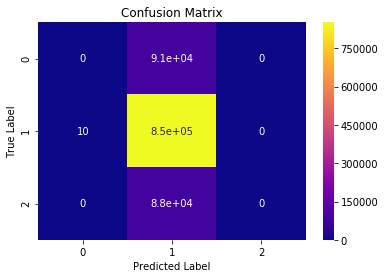

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
matrix = metrics.confusion_matrix(df_test[['class']], y_pred_lr_test)
sns.heatmap(matrix,annot=True,cbar=True, cmap='plasma')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

Now let's optimize a bit this model. 

In [0]:
df['Bytes']= df['Bytes'].apply(lambda r: float(r) if 'M' not in r else float(r.replace('M',''))*1000000)

In [0]:
df_test['Bytes']= df_test['Bytes'].apply(lambda r: float(r) if 'M' not in r else float(r.replace('M',''))*1000000)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr_op = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1, multi_class='multinomial')

X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets', 'Bytes']],  
    df[['class']], 
    test_size=0.20
)

pipe = Pipeline(steps=[('clf_lr_op', clf_lr_op)])
param_grid = {
    'clf_lr_op__max_iter': [50, 100, 1000]
}
t0 = time.time()
searchLR = GridSearchCV(pipe, param_grid, iid=False, cv=3, verbose=True, n_jobs=-1)
searchLR.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
print(searchLR.best_params_)
trainedLR = searchLR.best_estimator_.get_params()['clf_lr_op']
y_pred_LR = trainedLR.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_LR)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_LR,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_LR, average='macro')))
print(metrics.classification_report(y_test, y_pred_LR))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.6s finished


elapsed time = 145.29
{'clf_lr_op__max_iter': 50}
accuracy: 0.8272802030396791


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.275776
recall: 0.333309


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    attacker       0.00      0.00      0.00     15297
      normal       0.83      1.00      0.91    139846
      victim       0.00      0.00      0.00     13888

    accuracy                           0.83    169031
   macro avg       0.28      0.33      0.30    169031
weighted avg       0.68      0.83      0.75    169031



### Compare performance across different classifiers:
- Try a Decision Tree and a Random Forest. Does the performance improve? Why?


elapsed time = 1.39
accuracy: 0.9765900929415314
precision: 0.945378
recall: 0.952296
              precision    recall  f1-score   support

    attacker       0.97      0.97      0.97     14868
      normal       0.99      0.98      0.99    140046
      victim       0.87      0.90      0.89     14117

    accuracy                           0.98    169031
   macro avg       0.95      0.95      0.95    169031
weighted avg       0.98      0.98      0.98    169031

accuracy: 0.9812729069619707
precision: 0.949505
recall: 0.973936
              precision    recall  f1-score   support

    attacker       0.98      0.98      0.98     91009
      normal       0.99      0.98      0.99    851802
      victim       0.88      0.96      0.92     88262

    accuracy                           0.98   1031073
   macro avg       0.95      0.97      0.96   1031073
weighted avg       0.98      0.98      0.98   1031073



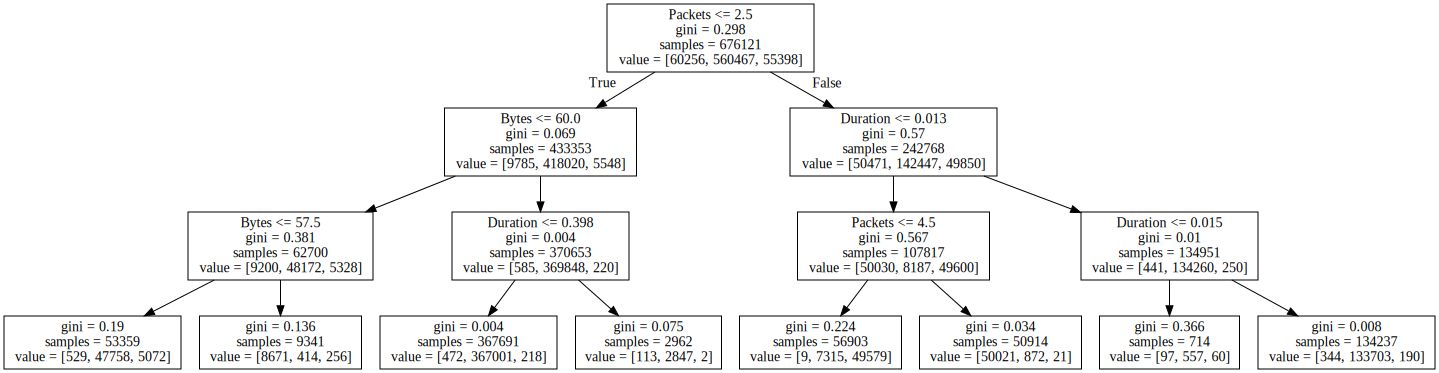

In [0]:
!pip install graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

X_train,  X_test, y_train, y_test = train_test_split( 
    df[['Duration', 'Packets', 'Bytes']],  
    df[['class']], 
    test_size=0.20
)

# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=3)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))

y_pred_dt = clf_dt.predict(df_test[['Duration', 'Packets', 'Bytes']])
print("accuracy: {}".format(metrics.accuracy_score(df_test[['class']], y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(df_test[['class']], y_pred_dt,average='macro')))
print("recall: {:g}".format(metrics.recall_score(df_test[['class']], y_pred_dt, average='macro')))
print(metrics.classification_report(df_test[['class']], y_pred_dt))

# visual tree
from sklearn import tree
graphviz.Source(export_graphviz(clf_dt, 
                                out_file=None,
                                feature_names=list(X_train.columns.values)))

In [0]:

X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets','Bytes']],  
    df[['class']], 
    test_size=0.20
)
from sklearn.ensemble import RandomForestClassifier
# define the classifier
clf_rf = RandomForestClassifier(n_estimators=700, n_jobs=-1, verbose=1)

# train the classifier
t0 = time.time()
clf_rf.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_rf = clf_rf.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_rf)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_rf,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_rf, average='macro')))
print(metrics.classification_report(y_test, y_pred_rf))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


elapsed time = 112.17


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    3.8s finished


accuracy: 0.9903627145316539
precision: 0.992583
recall: 0.963118
              precision    recall  f1-score   support

    attacker       0.99      0.99      0.99     14874
      normal       0.99      1.00      0.99    140368
      victim       1.00      0.90      0.95     13789

    accuracy                           0.99    169031
   macro avg       0.99      0.96      0.98    169031
weighted avg       0.99      0.99      0.99    169031



- How does GaussianNB perform on the numeric features?


In [0]:
X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets','Bytes']],  
    df[['class']], 
    test_size=0.20
)
from sklearn.naive_bayes import GaussianNB
# define the classifier
clf_nb = GaussianNB()

# train the classifier
t0 = time.time()
clf_nb.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_nb = clf_nb.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_nb)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_nb,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_nb, average='macro')))
print(metrics.classification_report(y_test, y_pred_nb))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


elapsed time = 1.32
accuracy: 0.2582544030384959
precision: 0.504523
recall: 0.652976
              precision    recall  f1-score   support

    attacker       0.40      0.83      0.54     14790
      normal       1.00      0.13      0.22    140507
      victim       0.11      1.00      0.20     13734

    accuracy                           0.26    169031
   macro avg       0.50      0.65      0.32    169031
weighted avg       0.87      0.26      0.25    169031



It doesn't perform well on the numeric features because of feature imbalance. Also, Naive Bayes assumption don't hold up in our case. 

- Beware running the SVM classifier: There is a lot of data here, so you would need to use a linear SVM rather than an RBF one, (and even then it may run out of memory without adjustments).


In [0]:
#from sklearn.svm import LinearSVC
#define the classifier
#clf_svc = LinearSVC(verbose=True)

# train the classifier
#t0 = time.time()
#clf_svc.fit(X_train, y_train)
#print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction 
#y_pred_svc = clf_svc.predict(X_test)

#print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_svc)))
#print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_svc,average='macro')))
#print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_svc, average='macro')))
#print(metrics.classification_report(y_test, y_pred_svc))
#takes a long time

- Convert the class to a binary attribute (malicious vs benign) and compute precision and recall values.
Anything of note?

In [0]:
df['classBin']= df['class'].apply(lambda x: 'benign' if x == 'normal' else 'malicious')

In [0]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split( 
    df[['Duration', 'Packets', 'Bytes']],  
    df[['classBin']], 
    test_size=0.20
)

from sklearn.linear_model import LogisticRegression

# define the classifier
clf_lr_bin = LogisticRegression(solver='lbfgs', max_iter=50, verbose=1, n_jobs=-1)

# train the classifier
t0 = time.time()
clf_lr_bin.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
y_pred_lr_bin = clf_lr_bin.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_lr_bin)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_lr_bin, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_lr_bin, average='macro')))
print(metrics.classification_report(y_test, y_pred_lr_bin))
df=df.drop(['classBin'], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.9s finished


elapsed time = 7.82
accuracy: 0.8279546355402263
precision: 0.413994
recall: 0.499975
              precision    recall  f1-score   support

      benign       0.83      1.00      0.91    139957
   malicious       0.00      0.00      0.00     29074

    accuracy                           0.83    169031
   macro avg       0.41      0.50      0.45    169031
weighted avg       0.69      0.83      0.75    169031



It gets better metrics, logistic regression works better with binary problems. However, there is no real progess in how the model perform. 

### Predicting another target:
- Rather than predicting the class variable, try to predict the “attackType” variable.


In [0]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(
    df[['Duration', 'Packets','Bytes']],  
    df[['attackType']], 
    test_size=0.20
)
from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=5)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))


elapsed time = 1.51
accuracy: 0.9842750738030303


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.781904
recall: 0.560959


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         ---       0.99      1.00      0.99    140259
  bruteForce       0.00      0.00      0.00        33
         dos       0.98      0.97      0.98     24979
    pingScan       1.00      0.21      0.35        66
    portScan       0.94      0.62      0.75      3694

    accuracy                           0.98    169031
   macro avg       0.78      0.56      0.61    169031
weighted avg       0.98      0.98      0.98    169031



- Is that variable easier/harder to predict?


It's harder, any model tested have worse performances. That's because we hare increasing the number of possible values of the feature the models have to predict. 


---



- The data is quite unbalanced. You could try to rebalance it by randomly down-sampling the majority class. Does it improve accuracy on the (not-down sampled) test data?

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

df_maj= df[df['class']=="normal"]
df_min= df[df['class'] != "normal"]
df_maj_sample= resample(df_maj, replace=False, n_samples=75124)
dfbl = pd.concat([df_maj_sample,df_min])

X_train,  X_test, y_train, y_test = train_test_split(
    dfbl[['Duration', 'Packets', 'Bytes']],  
    dfbl[['class']], 
    test_size=0.20
)

# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=3)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt,average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))

elapsed time = 0.31
accuracy: 0.9287875685391214
precision: 0.937255
recall: 0.927955
              precision    recall  f1-score   support

    attacker       0.85      0.99      0.91     15045
      normal       0.98      0.90      0.94     14970
      victim       0.98      0.90      0.94     13938

    accuracy                           0.93     43953
   macro avg       0.94      0.93      0.93     43953
weighted avg       0.94      0.93      0.93     43953



### Introducing more features:
- Introduce other features to the classifiers to see if you can further improve performance …


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df_one_hot = pd.get_dummies(df, columns=['Proto','Tos'])  
X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Src Pt','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription','Day of week','Time of day'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
    
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=5)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))



elapsed time = 1.77
accuracy: 0.9863811963485988
precision: 0.98034
recall: 0.957988
              precision    recall  f1-score   support

    attacker       0.99      0.98      0.99     14935
      normal       0.99      1.00      0.99    140022
      victim       0.96      0.90      0.93     14074

    accuracy                           0.99    169031
   macro avg       0.98      0.96      0.97    169031
weighted avg       0.99      0.99      0.99    169031



- Try adding day-of-week and time-of-day features into the classifier. Do they improve the performance?


In [0]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Src Pt','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))



elapsed time = 2.26
accuracy: 0.9890315977542581
precision: 0.987716
recall: 0.961871
              precision    recall  f1-score   support

    attacker       0.99      0.99      0.99     14944
      normal       0.99      1.00      0.99    140145
      victim       0.98      0.90      0.94     13942

    accuracy                           0.99    169031
   macro avg       0.99      0.96      0.97    169031
weighted avg       0.99      0.99      0.99    169031



- Split the “Flags” column up into separate columns for each of the flags (see code below for how to do that) and then make use of the flags as features. Do they improve the performance?


In [0]:
df_one_hot['Flag_1'] = [x[0] for x in df_one_hot['Flags']]
df_one_hot['Flag_2'] = [x[1] for x in df_one_hot['Flags']]
df_one_hot['Flag_3'] = [x[2] for x in df_one_hot['Flags']]
df_one_hot['Flag_4'] = [x[3] for x in df_one_hot['Flags']]
df_one_hot['Flag_5'] = [x[4] for x in df_one_hot['Flags']]
df_one_hot['Flag_6'] = [x[5] for x in df_one_hot['Flags']]
df_one_hot = pd.get_dummies(df_one_hot, columns=['Flag_1','Flag_2','Flag_3','Flag_4','Flag_5','Flag_6'])
df_one_hot.head(5)

,Date first seen,Duration,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,class,attackType,attackID,attackDescription,Day of week,Time of day,Proto_ICMP,Proto_IGMP,Proto_TCP,Proto_UDP,Tos_0,Tos_12,Tos_16,Tos_32,Tos_192,Flag_1_.,Flag_2_.,Flag_2_A,Flag_3_.,Flag_3_P,Flag_4_.,Flag_4_R,Flag_5_.,Flag_5_S,Flag_6_.,Flag_6_F
23,2017-03-15 00:01:17.728,0.047,192.168.220.16,45586,10000_35,443.0,5,906.0,1,.AP.S.,normal,---,---,---,2,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,1,0
36,2017-03-15 00:01:18.457,0.170,10003_195,80,192.168.220.16,48286.0,3,908.0,1,.AP.S.,normal,---,---,---,2,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0
30,2017-03-15 00:01:18.511,0.003,10002_113,443,192.168.220.16,49062.0,2,1089.0,1,.AP...,normal,---,---,---,2,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0
46,2017-03-15 00:01:22.400,0.000,EXT_SERVER,8082,192.168.220.15,37039.0,1,212.0,1,.AP...,normal,---,---,---,2,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0
51,2017-03-15 00:01:24.152,0.266,192.168.200.9,52290,EXT_SERVER,8082.0,2,319.0,1,.AP...,normal,---,---,---,2,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0


In [0]:

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Src Pt','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)


print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 2.70
accuracy: 0.9975507451295916
precision: 0.992926
recall: 0.995973
              precision    recall  f1-score   support

    attacker       1.00      0.99      1.00     15027
      normal       1.00      1.00      1.00    140043
      victim       0.98      1.00      0.99     13961

    accuracy                           1.00    169031
   macro avg       0.99      1.00      0.99    169031
weighted avg       1.00      1.00      1.00    169031



- Source IP addresses can be one of four categories (code in the appendix can be used to map IP addresses to the categories). Are the categories useful features?

In [0]:
def get_IP_category(ip_addr):
  if ip_addr == 'DNS':
    return 'DNS'
  elif ip_addr == 'EXT_SERVER':
    return 'EXT_SERVER'
  elif len(ip_addr.split('.')) == 4:
    return 'private'
  elif len(ip_addr.split('_')) == 2:
    return 'public'
  else:
    return '-'

df_one_hot['Src IP Addr Cat']= df_one_hot['Src IP Addr'].apply(lambda x: get_IP_category(x))
df_one_hot = pd.get_dummies(df_one_hot, columns=['Src IP Addr Cat'])

from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 2.86
accuracy: 0.9977045630683129
precision: 0.993439
recall: 0.996013
              precision    recall  f1-score   support

    attacker       1.00      0.99      1.00     14909
      normal       1.00      1.00      1.00    140094
      victim       0.98      1.00      0.99     14028

    accuracy                           1.00    169031
   macro avg       0.99      1.00      0.99    169031
weighted avg       1.00      1.00      1.00    169031



Yes,not so much, but still.. 

---



### Creating counts
- When detecting a Denial of Service (DoS) or portScan attack, counts of the number of requests from the same Source IP Address within a given time window could be an important feature. (For a DDoS attack, the same may be true of Destination IP Addresses.)


- Try adding one or more count fields to the dataset using the code from the Appendix.


In [0]:
df_one_hot['Cum Count Src IP Addr (10seconds)'] = df_one_hot.groupby(['Src IP Addr', pd.Grouper(freq='10S',
key='Date first seen')]).cumcount()
df_one_hot['Cum Count Src IP Addr (20seconds)'] = df_one_hot.groupby(['Src IP Addr', pd.Grouper(freq='20S',
key='Date first seen')]).cumcount()
df_one_hot['Cum Count Src IP Addr (60seconds)'] = df_one_hot.groupby(['Src IP Addr', pd.Grouper(freq='60S',
key='Date first seen')]).cumcount()


X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 3.59
accuracy: 0.9955570280007809
precision: 0.994048
recall: 0.986443
              precision    recall  f1-score   support

    attacker       1.00      0.98      0.99     14935
      normal       1.00      1.00      1.00    140259
      victim       0.99      0.98      0.98     13837

    accuracy                           1.00    169031
   macro avg       0.99      0.99      0.99    169031
weighted avg       1.00      1.00      1.00    169031



- Does the count field improve performance of the classifiers? What window or windows make sense?

In [0]:
# Not all of them
#let's see for each one of them
X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Cum Count Src IP Addr (20seconds)','Cum Count Src IP Addr (60seconds)','Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Cum Count Src IP Addr (10seconds)','Cum Count Src IP Addr (60seconds)','Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Cum Count Src IP Addr (10seconds)','Cum Count Src IP Addr (20seconds)','Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)
from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(max_depth=7)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 3.12
accuracy: 0.9945927078464897
precision: 0.983859
recall: 0.982716
              precision    recall  f1-score   support

    attacker       1.00      0.95      0.98     15055
      normal       1.00      1.00      1.00    140081
      victim       0.95      0.99      0.97     13895

    accuracy                           0.99    169031
   macro avg       0.98      0.98      0.98    169031
weighted avg       0.99      0.99      0.99    169031

elapsed time = 3.20
accuracy: 0.9949476723204619
precision: 0.984843
recall: 0.984128
              precision    recall  f1-score   support

    attacker       1.00      0.96      0.98     15111
      normal       1.00      1.00      1.00    140011
      victim       0.96      1.00      0.98     13909

    accuracy                           0.99    169031
   macro avg       0.98      0.98      0.98    169031
weighted avg       1.00      0.99      0.99    169031

elapsed time = 3.27
accuracy: 0.9949713366187267
precision: 0.9846

### Think about other analysis you could perform on the data:
- What other features might be interesting? Try to compute them by modifying the code in the Appendix.


In [0]:
X_train,  X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1),
    df_one_hot[['class']], 
    test_size=0.20
)

# define the classifier
clf_dt = DecisionTreeClassifier()

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt_at = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt_at)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt_at, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt_at, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt_at))

elapsed time = 6.13
accuracy: 0.9994912175873065
precision: 0.99902
recall: 0.998828
              precision    recall  f1-score   support

    attacker       1.00      1.00      1.00     14925
      normal       1.00      1.00      1.00    140062
      victim       1.00      1.00      1.00     14044

    accuracy                           1.00    169031
   macro avg       1.00      1.00      1.00    169031
weighted avg       1.00      1.00      1.00    169031



Now that we have all this features we could see the feature importance to see what are the mst relevant and see if our assertions are true

In [0]:
sorted(zip(clf_dt.feature_importances_,df_one_hot.drop(['Date first seen','Src Pt','Src IP Addr','Dst IP Addr','Dst Pt','Flags','class','attackType','attackID','attackDescription'],axis=1).columns ),reverse=True)

[(0.24503925507770385, 'Packets'),
 (0.05869776337111159, 'Flag_3_P'),
 (0.030763936609162913, 'Day of week'),
 (0.016737761906212605, 'Bytes'),
 (0.01590292978198225, 'Flag_5_S'),
 (0.01164787270562703, 'Flag_6_F'),
 (0.00996098746661452, 'Duration'),
 (0.0063332111378630795, 'Cum Count Src IP Addr (10seconds)'),
 (0.004608061547913568, 'Cum Count Src IP Addr (60seconds)'),
 (0.002623421416972823, 'Flag_4_.'),
 (0.0023650703245706715, 'Flag_6_.'),
 (0.002072036776031038, 'Flows'),
 (0.0016078472952877388, 'Cum Count Src IP Addr (20seconds)'),
 (0.0009531022245592731, 'Tos_16'),
 (0.0006143309215144892, 'Proto_IGMP '),
 (0.00033001403681708855, 'Proto_ICMP '),
 (0.00024792490286907774, 'Flag_3_.'),
 (0.00017658707958699777, 'Src IP Addr Cat_private'),
 (0.0001764706671310677, 'Src IP Addr Cat_DNS'),
 (0.00010840680287634136, 'Src IP Addr Cat_EXT_SERVER'),
 (1.98334070403264e-05, 'Tos_12'),
 (1.9757151619527616e-05, 'Proto_TCP  '),
 (0.0, 'Tos_32'),
 (0.0, 'Tos_192'),
 (0.0, 'Tos_0'),
 

- Try running some other analysis like clustering on the data.

In [0]:
from sklearn.cluster import (
    KMeans
)
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score
)

kmeans = KMeans(n_clusters=3).fit(
    df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1),
)
print(kmeans.cluster_centers_)
df_one_hot['cluster'] = kmeans.labels_
print(df_one_hot.groupby(['cluster', 'class']).size().reset_index().sort_values(['cluster', 'class']))

predicted_clusters = df_one_hot['cluster'].values
true_labels = df_one_hot['class'].values
print(homogeneity_score(true_labels, predicted_clusters))
print(completeness_score(true_labels, predicted_clusters))
print(v_measure_score(true_labels, predicted_clusters))

#agg = AgglomerativeClustering(n_clusters=3).fit(
#    df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1),
#)

#df_one_hot['cluster'] = agg.labels_
#df_one_hot['cluster'] = agg.labels_print(df_one_hot.groupby(['cluster', 'class']).size().reset_index().sort_values(['cluster', 'class']))

#predicted_clusters = df_one_hot['cluster'].values
#true_labels = df_one_hot['class'].values
#print(homogeneity_score(true_labels, predicted_clusters))
#print(completeness_score(true_labels, predicted_clusters))
#print(v_measure_score(true_labels, predicted_clusters))

[[ 1.11683420e-01  2.46043220e+04  2.42288873e+04  1.05068767e+01
   4.84508020e+03  1.00000000e+00  2.19666834e+00  1.23738396e+01
   1.27203430e-03  3.43153438e-05  8.74747812e-01  1.23945839e-01
   7.18842555e-01  1.18328772e-06  1.05312607e-04  2.80594200e-01
   4.56749059e-04  1.00000000e+00  1.44826134e-01  8.55173866e-01
   6.40326682e-01  3.59673318e-01  9.77820455e-01  2.21795450e-02
   6.86269011e-01  3.13730989e-01  7.17620219e-01  2.82379781e-01
   5.79704486e-02  9.81418833e-03  6.09058304e-01  3.23157059e-01
   4.87038621e+01  9.17598849e+01  2.27062724e+02]
 [ 4.39598519e+01  1.92684815e+04  2.93135185e+04  1.01813593e+05
   3.17840741e+08  1.00000000e+00  1.96296296e+00  1.23703704e+01
   2.16840434e-19  6.77626358e-21  1.00000000e+00  4.16333634e-17
   1.00000000e+00 -2.11758237e-22  4.06575815e-20 -1.11022302e-16
   0.00000000e+00  1.00000000e+00 -8.32667268e-17  1.00000000e+00
   1.11022302e-16  1.00000000e+00  1.00000000e+00  1.38777878e-17
   1.00000000e+00  0.0000

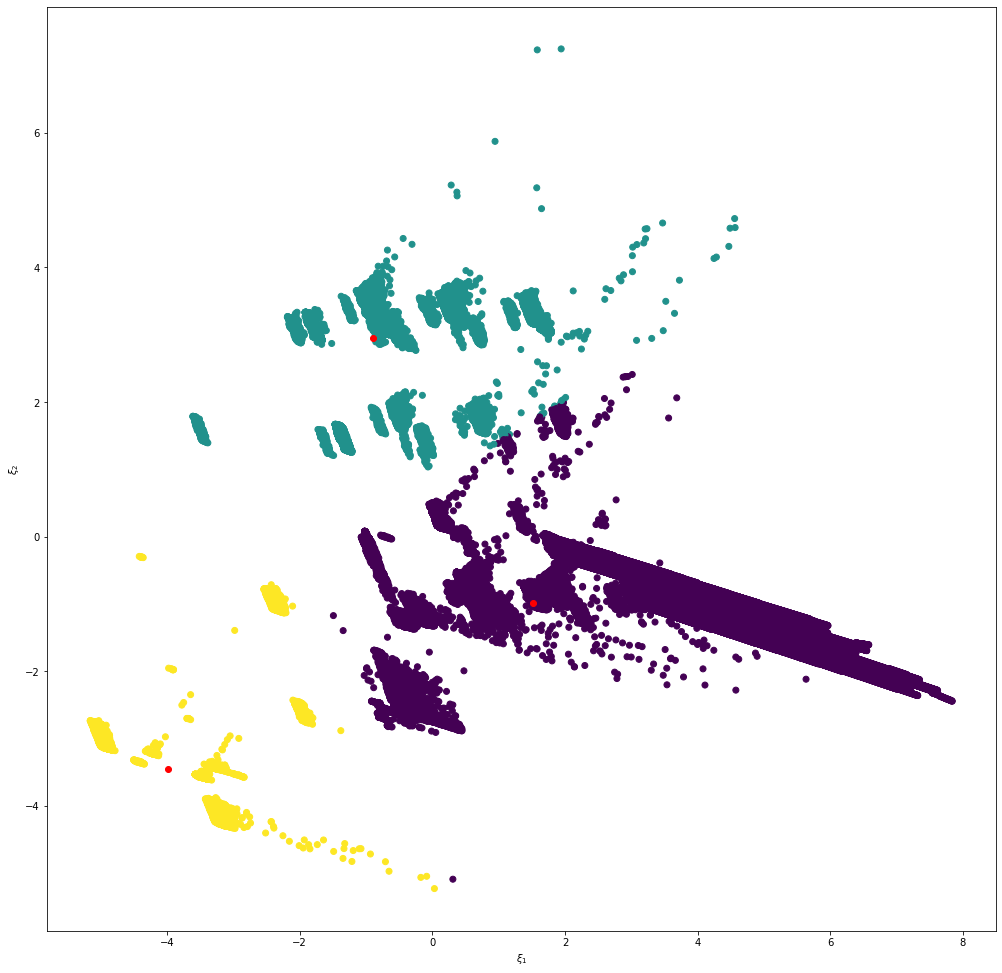

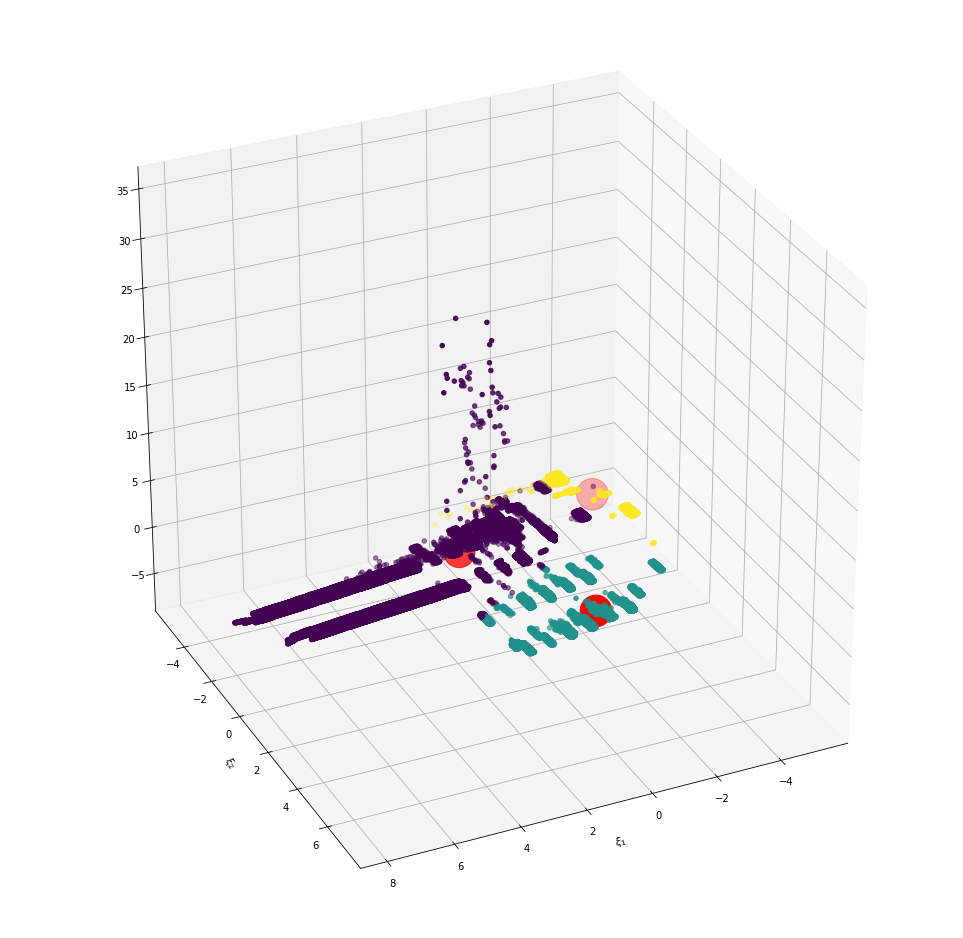

In [0]:
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('dim-red', pca)])
Xt = pipe.fit_transform(df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1))
kmeans = KMeans(n_clusters=3).fit(
    Xt
)
clusters = kmeans.predict(Xt)

fig, ax = plt.subplots(figsize=(17, 17))
ax.scatter(*Xt.T,c=clusters)
ax.scatter(*kmeans.cluster_centers_.T,c='red')
ax.set_xlabel('$\\xi_1$')
ax.set_ylabel('$\\xi_2$')
plt.show()

pca = PCA(n_components=3)
pipe = Pipeline([('scaler', StandardScaler()), ('dim-red', pca)])
Xt = pipe.fit_transform(df_one_hot.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1))
kmeans = KMeans(n_clusters=3).fit(
    Xt
)
clusters = kmeans.predict(Xt)

fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot( projection='3d')
ax.scatter(*Xt.T,c=clusters)
ax.scatter(*kmeans.cluster_centers_.T,c='red',s=1000)
ax.set_xlabel('$\\xi_1$')
ax.set_ylabel('$\\xi_2$')
ax.view_init(30,65)
plt.show()

In [0]:
from sklearn.ensemble import IsolationForest
from ipywidgets import interact, FloatSlider
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144

# truncate to two variables
pipe = Pipeline([('scaler', StandardScaler()), ('dim_red', PCA(n_components=2))])

Xt=df_one_hot[df_one_hot['class']=="normal"] #a bit ugly but it works
X_test= df_one_hot[df_one_hot['class']!="normal"]
Xt = pipe.fit_transform(Xt.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1))
X_test = pipe.fit_transform(X_test.drop(['Date first seen','Src IP Addr','Dst IP Addr','Flags','class','attackType','attackID','attackDescription'],axis=1))


In [0]:
def plot_isolation_forest(X, X_test):
    def plotter(contamination=0.2):
        clf = IsolationForest(n_estimators=100, contamination=contamination, behaviour='new')
        clf.fit(X)
    
        y_pred = clf.predict(X)
        outlier_rate = (y_pred == -1).sum()/len(X)
        X1, X2 = np.meshgrid(np.linspace(-20, 50), np.linspace(-20, 50))
        y_proba = clf.decision_function(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
        Z = y_proba.reshape(50, 50)
        fig = plt.figure(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.contourf(X1, X2, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
        plt.colorbar()
        a = plt.contour(X1, X2, Z, levels=[0], linewidths=2, colors='black')            
        b1 = plt.scatter(*X.T, c='blue')
        b2 = plt.scatter(*X_test.T, c='red')
        plt.title("outlier fraction: {:g}".format(outlier_rate))
        plt.legend([a.collections[0], b1, b2], ["boundary", "inliers", "outliers"], frameon=True, 
                   loc="lower right") 
    return plotter

cont_slider = FloatSlider(min=0.01, max=0.5, value=0.1, step=0.01, description="fraction")
interact(plot_isolation_forest(Xt, X_test), contamination=cont_slider);

interactive(children=(FloatSlider(value=0.1, description='fraction', max=0.5, min=0.01, step=0.01), Output()),…

Alternative link if the interactive plot doesn't load: https://drive.google.com/open?id=1h7d9MzNImphQ2lRFkNuOS6q9JfdYomMt


# APPENDIX
Some code to help with some of the tasks in part 1 of the assignment:
- Converting column from string to datetime format:

In [0]:
#df1['Date first seen'] = pd.to_datetime(df1['Date first seen'])

Getting time-of-day and day-of-week features from datetime object:

In [0]:
#df1['Date first seen'].dt.dayofweek
#df1['Date first seen'].dt.hour

Splitting the Flags field into separate fields:

In [0]:
#df1["Flag_1"] = [x[0] for x in df1["Flags"]]
#df1["Flag_2"] = [x[1] for x in df1["Flags"]]
#df1["Flag_3"] = [x[2] for x in df1["Flags"]]
#df1["Flag_4"] = [x[3] for x in df1["Flags"]]
#df1["Flag_5"] = [x[4] for x in df1["Flags"]]
#df1["Flag_6"] = [x[5] for x in df1["Flags"]]

Code for assigning Source IPs to 4 categories:

In [0]:
#def get_IP_category(ip_addr):
#if ip_addr == 'DNS':
#return 'DNS'
#elif ip_addr == 'EXT_SERVER':
#return 'EXT_SERVER'
#elif len(ip_addr.split('.')) == 4:
#return 'private'
#elif len(ip_addr.split('_')) == 2:
#return 'public'
#else:
#return '-'

Create new column with count of requests from same ‘Src IP Addr’ over the last 10 seconds:

In [0]:
#df1['Cum Count Src IP Addr (10seconds)'] = df1.groupby(['Src IP Addr', pd.Grouper(freq='10S',
#key='Date first seen')]).cumcount()

#*Sara Imbeni*

# *Giacomo Minello*

#*Utkan Peker*